In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install -q torch_geometric

In [3]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import pickle

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dims)
        self.decoder = Decoder(input_dim, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class Decoder(nn.Module):
    def __init__(self, input_dim, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, input_dim)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

class BaseNetwork(nn.Module):
  """
  A simple neural network with one hidden layer.
  """
  def __init__(self, in_features, hidden_size, out_features):
    """
    Initializes the network architecture.

    Args:
        in_features: Number of features in the input data.
        hidden_size: Number of neurons in the hidden layer.
        out_features: Number of features in the output layer.
    """
    super(BaseNetwork, self).__init__()

    # Define layers
    self.linear1 = nn.Linear(in_features, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_features)
    self.activation = nn.Softmax(dim=0)  # ReLU activation function (replace if needed)

  def forward(self, x):
    """
    Defines the forward pass of the network.

    Args:
        x: Input tensor of shape (batch_size, in_features).

    Returns:
        out: Output tensor of shape (batch_size, out_features).
    """
    # Hidden layer
    hidden = self.linear1(x)

    # Output layer with activation
    out = self.activation(self.linear2(hidden))

    return out

In [5]:
# structure_generator = tf.keras.models.load_model('data/decoder.h5')
structure_generator = None
feature_generator = torch.load('data/autoencoder.pth')
node_labeler = torch.load('data/node_label_embeder.pth')

In [6]:
# Check which device we are currently using.
if torch.cuda.is_available():
  device = torch.cuda.current_device()
  print("Current device:", torch.cuda.get_device_name(device))
  
else:
  print("Using CPU")

Current device: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


In [7]:
from torch_geometric.datasets import ZINC
dataset = ZINC(root = 'data', split='train') # valid, test

In [8]:
"""
Converts a row of data from the pytorch geometric ZINC dataset into
a matrix representation by stacking edges and padding. 

Args:
    layer: a row of data from the pytorch geometric ZINC dataset. 

Returns:
    A graph of the zinc dataset represented as a matrix.
"""
def convert_row(row):
    x = row.x
    edge_index = row.edge_index
    edge_attr = row.edge_attr

    G = nx.Graph()  # For undirected graphs

    # Unpack row and store result in edge_reprs.
    for edge_idx, (edge_i, edge_j) in enumerate(zip(edge_index[0], edge_index[1])):
        # Extract the attributes. 

        # Append edges.
        if not (edge_i.item() in G.nodes()):
            G.add_node(edge_i.item())
        if not (edge_j.item() in G.nodes()):
            G.add_node(edge_j.item())
        G.add_edge(edge_i.item(), edge_j.item(), attributes=None)

    return G
    

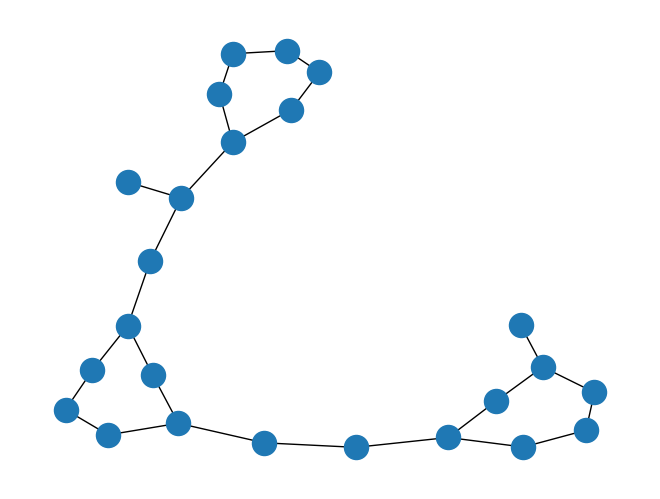

In [9]:
import random

LATENT_DIM = 400
BOND_DIM = 5

def generate_structure(structure_generator):

  row = random.choice(dataset)
    
  return convert_row(row)

  # # Generate structure
  # z = tf.random.normal((1, LATENT_DIM))
  # reconstruction_adjacency, reconstruction_features = structure_generator.predict(z)

  # # Process adjacency matrix
  # adjacency = tf.argmax(reconstruction_adjacency, axis=1)[0]
  # adjacency = adjacency < BOND_DIM - 1

  # # Filter out unconnected nodes
  # adjacency = np.array(adjacency)
  # adjacency = adjacency[np.any(adjacency != 0, axis=1)][:, np.any(adjacency != 0, axis=0)]

  # # Get NetworkX graph
  # return nx.Graph(adjacency)

graph = generate_structure(structure_generator)
nx.draw(graph)

In [10]:
max_len = 10

def revert_onehot(tensor):
    splits = torch.chunk(tensor.squeeze(), max_len)
    row_lst = []
    for split in splits:
        subsplits = torch.split(split, [4, 28, 28])
        # print(subsplits)
        e = torch.argmax(subsplits[0])
        v1 = torch.argmax(subsplits[1])
        v2 = torch.argmax(subsplits[2])
        row_lst.append(torch.tensor((e, v1, v2)))
    return torch.stack(row_lst)

def generate_feature_set(feature_generator):
    # Sample a random point in the latent space
    latent_dims = 2
    z = torch.randn(1, latent_dims).to(device)
    # print(z.get_device())

    # Decode the sampled latent vector to get a new vector
    return revert_onehot(feature_generator.decoder(z))

generate_feature_set(feature_generator)

tensor([[ 1,  0,  0],
        [ 2,  1,  1],
        [ 0,  4,  4],
        [ 0,  9,  9],
        [ 1, 15, 15],
        [ 3, 11,  5],
        [ 0, 12, 12],
        [ 0,  8,  3],
        [ 0, 25, 22],
        [ 1, 20, 20]])

In [11]:
import random

def re_name_walk(walk):
    mapping = {}
    next_num = 0
    new_walk = []
    for node in walk:
        if node in mapping.keys():
            new_walk.append(mapping[node])
        mapping[node] = next_num
        new_walk.append(mapping[node])
        next_num = next_num + 1
    return new_walk

def random_walk(G, start_node, walk_length):
    walk = [start_node]
    current_node = start_node
    for _ in range(walk_length):
        # Get neighbors of the current node
        neighbors = list(G.neighbors(current_node))
        if not neighbors:  # Handle case with isolated nodes
            break
        # Randomly choose a neighbor
        next_node = random.choice(neighbors)
        walk.append(next_node)
        current_node = next_node
    return re_name_walk(walk)

def get_node_label_fr_walk(model, walk, feature_tnsr):
  a_tnsr = torch.tensor(walk).float()
  b_tnsr = torch.flatten(feature_tnsr)
  c_tnsr = torch.cat((a_tnsr, b_tnsr))
  return model(c_tnsr)

In [12]:
walk_length = 3

def label_nodes (graph, node_labeler, feature_generator):

  node_features  = {}

  for node in range(len(graph.nodes)):
      walk = random_walk(graph, node, walk_length)
      feature_set = generate_feature_set(feature_generator)
      preds = get_node_label_fr_walk(node_labeler, walk[:walk_length], feature_set)
      pred = torch.argmax(preds)

      node_features[node] = pred.item()

  nx.set_node_attributes(graph, node_features, name="x")

label_nodes(graph, node_labeler, feature_generator)

In [13]:
# from torch_geometric.datasets import ZINC
# dataset = ZINC(root = 'data', split='train')

# edge_features = np.empty((2, 0))
# edge_labels = np.empty((1,0))

# ngraphs = 10000

# for idx in range(ngraphs):

#     graph = dataset[idx]

#     features = np.empty((2, len(graph.edge_attr)))

#     for edge_idx, edge  in enumerate(graph.edge_index.transpose(0, 1)):
#         features[:, edge_idx] = [graph.x[edge[0]].item(), graph.x[edge[1]].item()]

#     edge_features = np.append(edge_features, features, axis = 1)
#     edge_labels = np.append(edge_labels, graph.edge_attr)

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split

# classifier = DecisionTreeClassifier()
# x_train, x_test, y_train, y_test = train_test_split(edge_features.T, edge_labels)

# classifier.fit(x_train, y_train)
# print("Accuracy:", classifier.score(x_test, y_test))

# edge_labeler = classifier

with open('data/edge_labeler.pkl', 'rb') as f:
    edge_labeler = pickle.load(f)

c:\Users\menez\Documents\VSCode\COMP459\COMP459GraphGenerator\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
def label_edges (graph, edge_labeler):

  for edge  in graph.edges:
    edge_label = edge_labeler.predict([[graph.nodes[edge[0]]['x'], graph.nodes[edge[1]]['x']]]).item()
    graph[edge[0]][edge[1]]['x'] = edge_label

label_edges(graph, edge_labeler)

In [15]:
def generate (structure_generator, feature_generator, node_labeler, edge_labeler):
  graph = generate_structure(structure_generator)
  label_nodes(graph, node_labeler, feature_generator)
  label_edges(graph, edge_labeler)
  return graph

graph = generate(structure_generator, feature_generator, node_labeler, edge_labeler)

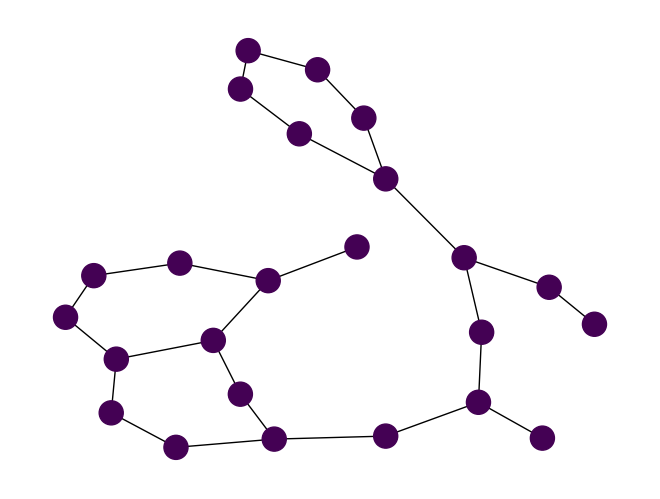

In [16]:
node_color_map = [data['x'] for node, data in graph.nodes(data=True)]
edge_width_map = [data['x'] for edge_i, edge_j, data in graph.edges(data=True)]
nx.draw(graph, node_color=node_color_map)

In [17]:
import os.path as osp
import torch
import torch.nn.functional as F
from torch.nn import ModuleList, Embedding
from torch.nn import Sequential, ReLU, Linear
from torch.nn.modules.module import T
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.utils import degree
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, global_add_pool
from mma_conv import MMAConv
import argparse
import numpy as np

In [18]:
# Define neural network model
class Net(torch.nn.Module):
    """
    Neural network class definition.
    """
    def __init__(self, args, aggregator_list, scaler_list):
        """
        Initializes the neural network.

        Args:
        - args: Command line arguments.
        - aggregator_list: List of aggregators.
        - scaler_list: List of scalers.
        """
        super(Net, self).__init__()

        # Define node and edge embeddings
        self.node_emb = Embedding(21, 75)
        self.edge_emb = Embedding(4, 50)

        # Define aggregators and scalers
        aggregators = aggregator_list
        scalers = scaler_list

        # Define convolutional layers and batch normalization layers
        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        
        # Add four convolutional layers with corresponding batch normalization layers
        for _ in range(4): # 4 ------> number of layers
            conv = MMAConv(in_channels=75, out_channels=75,
                           aggregators=aggregators, scalers=scalers, deg=deg,
                           edge_dim=50, towers=5, pre_layers=1, post_layers=1,
                           mask = args.mask, divide_input=False)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(75))

        # Define fully connected layers
        self.mlp = Sequential(Linear(75, 50), ReLU(), Linear(50, 25), ReLU(),
                              Linear(25, 1))

    def forward(self, x, edge_index, edge_attr, batch):
        """
        Defines the forward pass of the neural network.

        Args:
        - x: Node features.
        - edge_index: Edge indices.
        - edge_attr: Edge attributes.
        - batch: Batch indices.

        Returns:
        - The output of the neural network.
        """
        x = self.node_emb(x.squeeze())
        edge_attr = self.edge_emb(edge_attr)

        # Perform convolutional and batch normalization operations
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = F.relu(batch_norm(conv(x, edge_index, edge_attr)))
        
        # Perform global pooling
        x = global_add_pool(x, batch)
        
        # Perform fully connected layers
        return self.mlp(x)

In [19]:
normal_mma_model = torch.load("data/finalNormalMMA.pth")

In [20]:
from torch.utils.data import DataLoader, Dataset

# Add your custom dataset class here
class MyMMADataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [21]:
aug_dataset = MyMMADataset([])

In [22]:
def graph_to_row(graph):
    # Make x
    x = []
    edge_index = graph.edges()
    edge_attr = []
    batch = []
    for node, data in graph.nodes(data=True):
        x.append(data['x'])
    # Make edge_index
    # for u, v in graph.edges():
    #     x.append(attrib(node))
    # Make edge_attr
    for edge_i, edge_j, data in graph.edges(data=True):
        edge_attr.append(data['x'])
    # Make batch
    for node in graph.nodes():
        batch.append(0)
    # Make y
    x = torch.tensor(x).to(device).long()
    edge_index = torch.transpose(torch.tensor(list(edge_index)), 0, 1).to(device).long()
    edge_attr = torch.tensor(edge_attr).to(device).long()
    batch = torch.tensor(batch).to(device).long()
    sol = normal_mma_model(x, edge_index, edge_attr, batch)
    # print(sol)

    return (x, edge_index, edge_attr, batch, sol)

graph_to_row(graph)

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        device='cuda:0'),
 tensor([[ 0,  1,  2,  2,  3, 18, 18,  4,  4,  6,  7,  7,  8, 17,  9, 10, 10, 11,
          16, 12, 13, 14, 19, 23, 20, 21],
         [ 1,  2,  3, 18,  4, 19, 23,  5,  6,  7,  8, 17,  9, 16, 10, 11, 16, 12,
          14, 13, 14, 15, 20, 22, 21, 22]], device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'),
 tensor([[-7.4612]], device='cuda:0', grad_fn=<AddmmBackward0>))

In [23]:
# 9.3 s for 100
for row_i in range(100):
    graph = generate(structure_generator, feature_generator, node_labeler, edge_labeler)
    aug_dataset.data.append(graph_to_row(graph))

In [24]:
import os.path as osp
import os
import torch
import torch.nn.functional as F
from torch.nn import ModuleList, Embedding
from torch.nn import Sequential, ReLU, Linear
from torch.nn.modules.module import T
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.utils import degree
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, global_add_pool
from mma_conv import MMAConv
import argparse
import numpy as np

'''
Multi-Mask Aggregators 
Adapted from the source code https://github.com/pyg-team/pytorch_geometric/blob/master/examples/pna.py
'''

# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.0005, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden_dim', type=int, default=16, help='Number of hidden dimensipns.')
parser.add_argument('--out_dim', type=int, default=16, help='Number of out dimensions.')
parser.add_argument('--edge_dim', type=int, default=16, help='Number of edge dimensions.')
parser.add_argument('--dropout', type=float, default=0.5, help='Dropout rate (1 - keep probability).')
parser.add_argument('--batch_size', type=int, default=16, help='Number of batch size.')
parser.add_argument('--tower', type=int, default=1, help='Number of towers')
parser.add_argument('--aggregators', type=str, default="mean,max,min", help='choose your aggregators')
parser.add_argument('--scalers', type=str, default="identity,amplification,attenuation", help='choose your scalers')
parser.add_argument('--L', type=int, default=4, help='Enter number of layers')
parser.add_argument('--mask', type=bool, default=True, help='decide using mask or not')

# Parse arguments
args = parser.parse_args(args=[])

# Set random seed for reproducibility
np.random.seed(args.seed)
torch.manual_seed(args.seed)

# Load ZINC dataset
path = "data"
train_dataset = ZINC(path, subset=True, split='train')
val_dataset = ZINC(path, subset=True, split='val')
test_dataset = ZINC(path, subset=True, split='test')

# print("train_dataset_entry: " + str(train_dataset[0]))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# data_entry = list(train_loader)[0]

# print("x: " + str(data_entry.x))
# print("edge index: " + str(data_entry.edge_index))
# print("edge_attr: " + str(data_entry.edge_attr))
# print("y: " + str(data_entry.y))
# print("batch: " + str(data_entry.batch))

# print("x: " + str(data_entry.x.shape))
# print("edge index: " + str(data_entry.edge_index.shape))
# print("edge_attr: " + str(data_entry.edge_attr.shape))
# print("y: " + str(data_entry.y.shape))
# print("batch: " + str(data_entry.batch.shape))


val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Compute in-degree histogram over training data.
deg = torch.zeros(5, dtype=torch.long)
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

# Define neural network model
class Net(torch.nn.Module):
    """
    Neural network class definition.
    """
    def __init__(self, args, aggregator_list, scaler_list):
        """
        Initializes the neural network.

        Args:
        - args: Command line arguments.
        - aggregator_list: List of aggregators.
        - scaler_list: List of scalers.
        """
        super(Net, self).__init__()

        # Define node and edge embeddings
        self.node_emb = Embedding(21, 75)
        self.edge_emb = Embedding(4, 50)

        # Define aggregators and scalers
        aggregators = aggregator_list
        scalers = scaler_list

        # Define convolutional layers and batch normalization layers
        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        
        # Add four convolutional layers with corresponding batch normalization layers
        for _ in range(4): # 4 ------> number of layers
            conv = MMAConv(in_channels=75, out_channels=75,
                           aggregators=aggregators, scalers=scalers, deg=deg,
                           edge_dim=50, towers=5, pre_layers=1, post_layers=1,
                           mask = args.mask, divide_input=False)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(75))

        # Define fully connected layers
        self.mlp = Sequential(Linear(75, 50), ReLU(), Linear(50, 25), ReLU(),
                              Linear(25, 1))

    def forward(self, x, edge_index, edge_attr, batch):
        """
        Defines the forward pass of the neural network.

        Args:
        - x: Node features.
        - edge_index: Edge indices.
        - edge_attr: Edge attributes.
        - batch: Batch indices.

        Returns:
        - The output of the neural network.
        """
        x = self.node_emb(x.squeeze())
        edge_attr = self.edge_emb(edge_attr)

        # Perform convolutional and batch normalization operations
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = F.relu(batch_norm(conv(x, edge_index, edge_attr)))
        
        # Perform global pooling
        x = global_add_pool(x, batch)
        
        # Perform fully connected layers
        return self.mlp(x)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize neural network, move to GPU if available
model = Net(args, aggregator_list=args.aggregators.split(","), scaler_list=args.scalers.split(",")).to(device)

# Initialize optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr=0.00001)

def train(epoch):
    """
    Train the neural network model for a given number of epochs using the training data.

    Args:
        epoch (int): The current epoch number.

    Returns:
        The average loss across the training dataset for the current epoch.
    """
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = (out.squeeze() - data.y).abs().mean()

        for example_i in range(1):
            data = graph_to_row(graph)
            out = model(data[0], data[1], data[2], data[3])
            loss += (out.squeeze() - data[-1]).abs().mean()
            
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    """
    Evaluate the performance of the neural network model on the given data loader.

    Args:
        loader (DataLoader): The data loader to evaluate the model on.

    Returns:
        The average error across the dataset.
    """
    model.eval()

    total_error = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        total_error += (out.squeeze() - data.y).abs().sum().item()

    return total_error / len(loader.dataset)


# Train the model for the given number of epochs
for epoch in range(args.epochs):
    # Train the model for one epoch
    loss = train(epoch)
    
    # Evaluate the model on the validation and test data
    val_mae = test(val_loader)
    test_mae = test(test_loader)
    
    # Update the learning rate using the ReduceLROnPlateau scheduler
    scheduler.step(val_mae)
    
    # Print the epoch number, training loss, and evaluation metrics
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_mae:.4f}, '
          f'Test: {test_mae:.4f}')
    
    torch.save(model, "data/finalAugmentedMMA.pth")

Epoch: 00, Loss: 0.0345, Val: 3.5764, Test: 3.6622
Epoch: 01, Loss: 0.0156, Val: 2.8478, Test: 2.8837
Epoch: 02, Loss: 0.0144, Val: 2.0794, Test: 2.1195
Epoch: 03, Loss: 0.0141, Val: 1.8477, Test: 1.9110
Epoch: 04, Loss: 0.0139, Val: 2.1568, Test: 2.1963
Epoch: 05, Loss: 0.0129, Val: 1.7470, Test: 1.7657
Epoch: 06, Loss: 0.0125, Val: 1.4795, Test: 1.5071
Epoch: 07, Loss: 0.0122, Val: 1.3453, Test: 1.4085
Epoch: 08, Loss: 0.0125, Val: 1.3730, Test: 1.4540
Epoch: 09, Loss: 0.0128, Val: 1.3485, Test: 1.3865
Epoch: 10, Loss: 0.0123, Val: 1.4978, Test: 1.4819
Epoch: 11, Loss: 0.0121, Val: 1.3070, Test: 1.3293
Epoch: 12, Loss: 0.0126, Val: 1.6265, Test: 1.6311
Epoch: 13, Loss: 0.0122, Val: 1.4061, Test: 1.4336
Epoch: 14, Loss: 0.0124, Val: 1.5056, Test: 1.5573
Epoch: 15, Loss: 0.0112, Val: 1.4176, Test: 1.4536
Epoch: 16, Loss: 0.0119, Val: 1.2600, Test: 1.3199
Epoch: 17, Loss: 0.0115, Val: 1.8135, Test: 1.8556
Epoch: 18, Loss: 0.0116, Val: 1.8409, Test: 1.8840
Epoch: 19, Loss: 0.0117, Val: 1